**Preparar el Dataset en PyTorch**
- clase PascalVOCDataset, que hereda de la clase Dataset de PyTorch. Esta clase se usa para cargar un conjunto de datos en formato Pascal VOC y preparar las imágenes y las etiquetas para la detección de objetos

In [ ]:
import os
import torch
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class PascalVOCDataset(Dataset): # clase que hereda de Dataset de PyTorch
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.classes = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"] # lista de clases
        self.class_to_idx = {name: idx for idx, name in enumerate(self.classes)}
        
        # List all image files in the dataset
        self.images = []
        for label_dir in os.listdir(root):
            label_path = os.path.join(root, label_dir)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith(".jpg"):
                        self.images.append(os.path.join(label_dir, file))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        label_path = img_path.replace(".jpg", ".xml")
        
        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }
        
        return img, target
    
    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx[label])
        
        return boxes, labels # retorna las cajas y las etiquetas

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn # importar el modelo Faster R-CNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # importar el predictor de Faster R-CNN

def get_model(num_classes): # función para obtener el modelo preentrenado en COCO
    # Cargar el modelo preentrenado en COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Obtener el número de características del clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Reemplazar el predictor para que se ajuste al número de clases de nuestro dataset
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model # retorna el modelo preentrenado en COCO

# Número de clases (5 plantas + 1 fondo)
num_classes = 6
model = get_model(num_classes) 

c:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\entorno_Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\entorno_Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Configuración del Dataset y la División en Entrenamiento y Validación**

In [ ]:
from torch.utils.data import random_split

# Configurar transformaciones y dividir el dataset
dataset = PascalVOCDataset(root= r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\DatasetPascall")
train_size = int(0.8 * len(dataset)) # 80% de los datos para entrenamiento
val_size = len(dataset) - train_size # 20% de los datos para validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # dividir el dataset en entrenamiento y validación 

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x))) # DataLoader para el conjunto de entrenamiento
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x))) # DataLoader para el conjunto de validación

# Configurar el dispositivo
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Definir el optimizador
params = [p for p in model.parameters() if p.requires_grad] # parámetros que requieren gradiente 
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # optimizador SGD 

**guarda el estado del modelo y del optimizador durante el entrenamiento**

In [6]:
import os

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir="checkpoints"):
    # Crear el directorio de checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Guardar el checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint guardado en {checkpoint_path}")

**ENTRENAMIENTO**

In [7]:
from torchvision import transforms

# Transformación de PIL a tensor
to_tensor = transforms.ToTensor()

num_epochs = 10
checkpoint_dir = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints"  # Directorio donde se guardarán los checkpoints

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        # Convertir imágenes a tensores y mover al dispositivo
        images = [to_tensor(image).to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Calcular pérdidas y optimizar
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
    
    # Imprimir la pérdida promedio de la época
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")
    
    # Guardar el checkpoint al final de la época
    save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_dir)

Epoch 1/10, Loss: 0.03589863850772381
Checkpoint guardado en C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints\checkpoint_epoch_1.pth
Epoch 2/10, Loss: 0.030616343695949764
Checkpoint guardado en C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints\checkpoint_epoch_2.pth
Epoch 3/10, Loss: 0.03126133307437413
Checkpoint guardado en C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints\checkpoint_epoch_3.pth
Epoch 4/10, Loss: 0.032659124159161
Checkpoint guardado en C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints\checkpoint_epoch_4.pth
Epoch 5/10, Loss: 0.031157592721888797
Checkpoint guardado en C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICI

KeyboardInterrupt: 

**CARGA DEL MODELO**

In [5]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint cargado desde {checkpoint_path}, Epoch {epoch}, Loss: {loss}")
    return model, optimizer, epoch, loss

# Cargar un checkpoint específico
checkpoint_path = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints\checkpoint_epoch_5.pth"
model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_path)

C:\Users\CHRISTIAN\AppData\Local\Temp\ipykernel_12792\3600563422.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint cargado desde C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\checkpoints\checkpoint_epoch_5.pth, Epoch 5, Loss: 0.031157592721888797


In [6]:
model.eval()  # Cambiar el modelo a modo de evaluación

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**Evaluacion de el modelo**

In [7]:
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

# Transformación de PIL a tensor
to_tensor = transforms.ToTensor()

def evaluate(model, data_loader, device):
    model.eval()  # Asegurarse de que el modelo esté en modo de evaluación
    results = []
    
    with torch.no_grad():  # No necesitamos gradientes para la evaluación
        for images, targets in data_loader:
            # Convertir cada imagen a tensor y moverla al dispositivo
            images = [to_tensor(image).to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Realizar las predicciones
            output = model(images)
            results.append(output)
    
    return results


# Crear el DataLoader para el conjunto de validación
#al_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Evaluar el modelo
results = evaluate(model, val_loader, device)

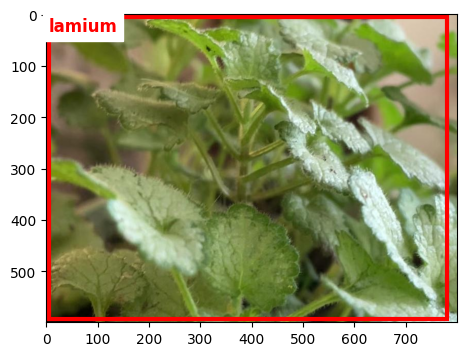

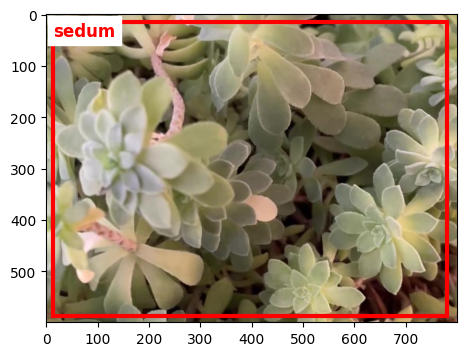

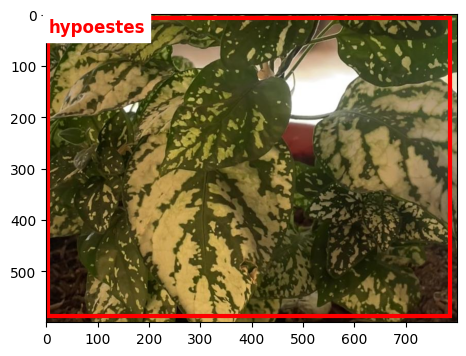

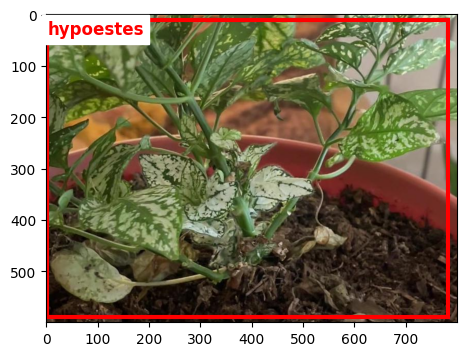

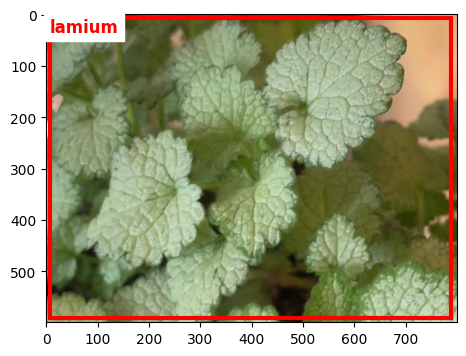

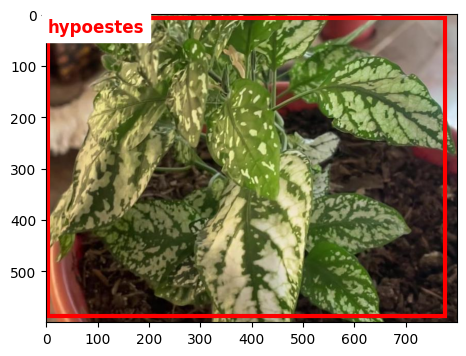

In [38]:
from torchvision import transforms
import matplotlib.pyplot as plt

# Definir la transformación de PIL a tensor
to_tensor = transforms.ToTensor()

# Lista de nombres de las clases
#class_names = ["chamaelobivia", "lamium", "hypoestes", "sedum", "rosario"]
class_names = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"]

# Función para mostrar una imagen con sus predicciones
def show_result(image, prediction):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a formato numpy

    for box, label in zip(prediction['boxes'], prediction['labels']):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
        class_name = class_names[label.item()]
        
        # Dibujar la caja
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
        
        # Añadir el texto de la clase en la esquina superior izquierda de la caja
        ax.text(xmin, ymin, class_name, color="red", fontsize=12, weight="bold", va="top", ha="left", backgroundcolor="white")

    plt.show()

# Mostrar los resultados para las primeras imágenes
for i, (images, targets) in enumerate(val_loader):
    # Convertir cada imagen a tensor y moverla al dispositivo
    images = [to_tensor(image).to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    # Realizar las predicciones
    predictions = model(images)
    
    # Mostrar el resultado para la primera imagen en el batch
    show_result(images[0], predictions[0])
    
    if i == 5:  # Mostrar solo las primeras 5 imágenes
        break

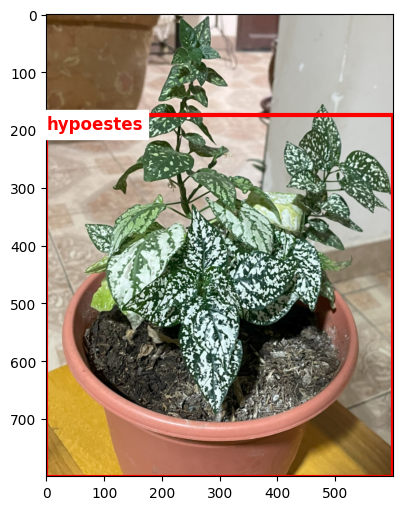

In [39]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"]

# Cargar la nueva imagen
image_path = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\fotos\IMG_4501-edit.jpg"
image = Image.open(image_path).convert("RGB")

# Definir la transformación que se aplicó a las imágenes de entrenamiento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 600)),  # O el tamaño adecuado
])

# Aplicar la transformación a la nueva imagen
image_tensor = transform(image).unsqueeze(0).to(device)  # Añadir batch dimension

# Poner el modelo en modo de evaluación
model.eval()

# Realizar la predicción para la nueva imagen
with torch.no_grad():
    prediction = model(image_tensor)



# Función para mostrar la imagen con las predicciones
def show_result(image, prediction):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a formato numpy

    for box, label in zip(prediction['boxes'], prediction['labels']):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
        class_name = class_names[label.item()]
        
        # Dibujar la caja
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
        
        # Añadir el texto de la clase en la esquina superior izquierda de la caja
        ax.text(xmin, ymin, class_name, color="red", fontsize=12, weight="bold", va="top", ha="left", backgroundcolor="white")

    plt.show()

# Mostrar la imagen con las predicciones
show_result(image_tensor[0], prediction[0])

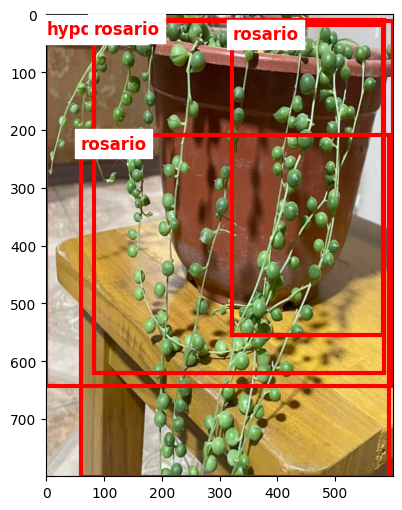

In [40]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"]

# Cargar la nueva imagen
image_path = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\fotos\IMG_4503-edit.jpg"
image = Image.open(image_path).convert("RGB")

# Definir la transformación que se aplicó a las imágenes de entrenamiento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 600)),  # O el tamaño adecuado
])

# Aplicar la transformación a la nueva imagen
image_tensor = transform(image).unsqueeze(0).to(device)  # Añadir batch dimension

# Poner el modelo en modo de evaluación
model.eval()

# Realizar la predicción para la nueva imagen
with torch.no_grad():
    prediction = model(image_tensor)



# Función para mostrar la imagen con las predicciones
def show_result(image, prediction):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a formato numpy

    for box, label in zip(prediction['boxes'], prediction['labels']):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
        class_name = class_names[label.item()]
        
        # Dibujar la caja
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
        
        # Añadir el texto de la clase en la esquina superior izquierda de la caja
        ax.text(xmin, ymin, class_name, color="red", fontsize=12, weight="bold", va="top", ha="left", backgroundcolor="white")

    plt.show()

# Mostrar la imagen con las predicciones
show_result(image_tensor[0], prediction[0])

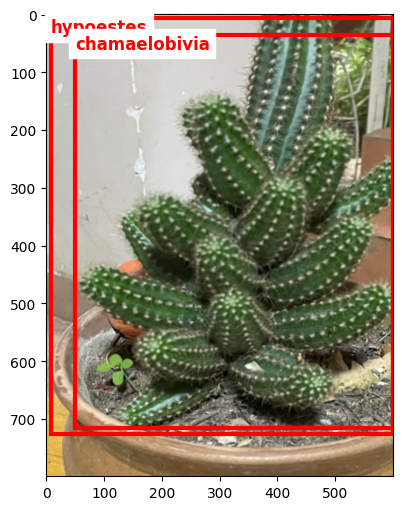

In [41]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"]

# Cargar la nueva imagen
image_path = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\fotos\IMG_4507-edit.jpg"
image = Image.open(image_path).convert("RGB")

# Definir la transformación que se aplicó a las imágenes de entrenamiento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 600)),  # O el tamaño adecuado
])

# Aplicar la transformación a la nueva imagen
image_tensor = transform(image).unsqueeze(0).to(device)  # Añadir batch dimension

# Poner el modelo en modo de evaluación
model.eval()

# Realizar la predicción para la nueva imagen
with torch.no_grad():
    prediction = model(image_tensor)



# Función para mostrar la imagen con las predicciones
def show_result(image, prediction):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a formato numpy

    for box, label in zip(prediction['boxes'], prediction['labels']):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
        class_name = class_names[label.item()]
        
        # Dibujar la caja
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
        
        # Añadir el texto de la clase en la esquina superior izquierda de la caja
        ax.text(xmin, ymin, class_name, color="red", fontsize=12, weight="bold", va="top", ha="left", backgroundcolor="white")

    plt.show()

# Mostrar la imagen con las predicciones
show_result(image_tensor[0], prediction[0])

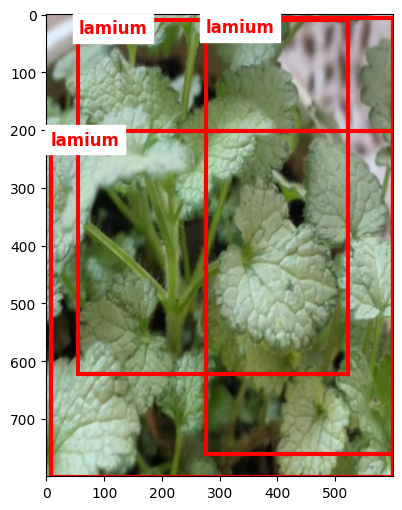

In [43]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"]

# Cargar la nueva imagen
image_path = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\fotos\IMG_4511-edit.jpg"
image = Image.open(image_path).convert("RGB")

# Definir la transformación que se aplicó a las imágenes de entrenamiento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 600)),  # O el tamaño adecuado
])

# Aplicar la transformación a la nueva imagen
image_tensor = transform(image).unsqueeze(0).to(device)  # Añadir batch dimension

# Poner el modelo en modo de evaluación
model.eval()

# Realizar la predicción para la nueva imagen
with torch.no_grad():
    prediction = model(image_tensor)



# Función para mostrar la imagen con las predicciones
def show_result(image, prediction):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a formato numpy

    for box, label in zip(prediction['boxes'], prediction['labels']):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
        class_name = class_names[label.item()]
        
        # Dibujar la caja
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
        
        # Añadir el texto de la clase en la esquina superior izquierda de la caja
        ax.text(xmin, ymin, class_name, color="red", fontsize=12, weight="bold", va="top", ha="left", backgroundcolor="white")

    plt.show()

# Mostrar la imagen con las predicciones
show_result(image_tensor[0], prediction[0])

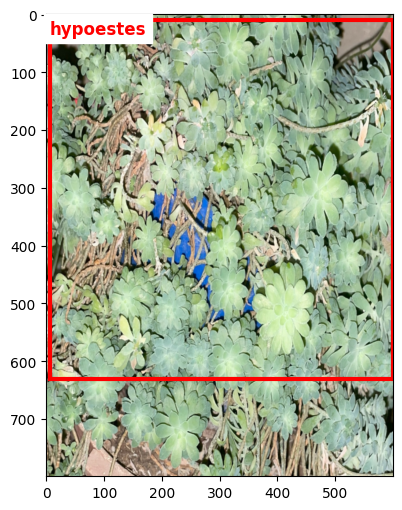

In [44]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["__background__", "chamaelobivia", "hypoestes", "lamium", "rosario", "sedum"]

# Cargar la nueva imagen
image_path = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\notebooks\EfficientDet\fotos\IMG_4505-edit.jpg"
image = Image.open(image_path).convert("RGB")

# Definir la transformación que se aplicó a las imágenes de entrenamiento
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 600)),  # O el tamaño adecuado
])

# Aplicar la transformación a la nueva imagen
image_tensor = transform(image).unsqueeze(0).to(device)  # Añadir batch dimension

# Poner el modelo en modo de evaluación
model.eval()

# Realizar la predicción para la nueva imagen
with torch.no_grad():
    prediction = model(image_tensor)



# Función para mostrar la imagen con las predicciones
def show_result(image, prediction):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convertir a formato numpy

    for box, label in zip(prediction['boxes'], prediction['labels']):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
        class_name = class_names[label.item()]
        
        # Dibujar la caja
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
        
        # Añadir el texto de la clase en la esquina superior izquierda de la caja
        ax.text(xmin, ymin, class_name, color="red", fontsize=12, weight="bold", va="top", ha="left", backgroundcolor="white")

    plt.show()

# Mostrar la imagen con las predicciones
show_result(image_tensor[0], prediction[0])